In [78]:
import os
import splitfolders 

input_dir = os.path.join('flowers/')
output_dir = os.path.join('flowers_splitted/')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8, .2), group_prefix=None) 
train_dir = os.path.join('flowers_splitted/train/')
test_dir = os.path.join('flowers_splitted/val/')

Copying files: 1497 files [00:04, 369.29 files/s]


In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_generator(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 214,
                                  class_mode = 'categorical',
                                  subset='training')
 
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(75,75),
                                 batch_size = 37,
                                 class_mode = 'categorical')    
    
    return train_generator, test_generator

In [80]:
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 1197 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential([
    Conv2D(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='softmax')
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 60, 60, 8)         6152      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 30, 30, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 6, 6, 64)       

In [82]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [83]:
history = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=100,
      verbose=1)

Epoch 1/100
10/10 [==============================] - 16s 1s/step - loss: 0.6936 - accuracy: 0.5000


[[1.]]


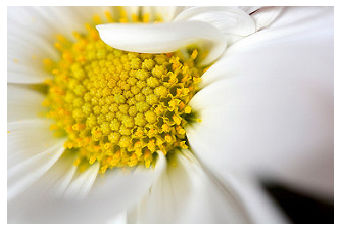

In [84]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def import_and_predict(image_data, label):
    
    #read image
    img = cv2.imread(image_data)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    # resize and reshape the image
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    img_reshape = img_resize[np.newaxis,...]
    
    #predict the image
    prediction = model.predict(img_reshape)
    print(prediction)
    
    label_prediction = label[np.argmax(prediction)]
    
    return label_prediction
 
label = os.listdir(test_dir)
image1_dir = os.path.join(test_dir+'daisy/image135.jpg')

prediction = import_and_predict(image1_dir, label)

In [85]:
label


['daisy', 'sunflower']

In [86]:
prediction

'daisy'

In [87]:
#############Baye's Classifier####################################

In [88]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
kernel_prior_fn = tfpl.default_multivariate_normal_fn
bias_prior_fn = tfpl.default_multivariate_normal_fn,

In [89]:
kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False)
bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False)

In [90]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3457
kernel_divergence_fn = divergence_fn
bias_divergence_fn = divergence_fn

In [91]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3457
tfpl.Convolution2DReparameterization(
     input_shape=(75,75,3), 
     filters=8, 
     kernel_size=16,
     activation='relu',
     kernel_prior_fn = tfpl.default_multivariate_normal_fn,
     kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
     kernel_divergence_fn = divergence_fn,
     bias_prior_fn = tfpl.default_multivariate_normal_fn,
     bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
     bias_divergence_fn = divergence_fn)

In [92]:
tfpl.DenseReparameterization(
     units = tfpl.OneHotCategorical.params_size(5), 
     activation=None,
     kernel_prior_fn = tfpl.default_multivariate_normal_fn,
     kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
     kernel_divergence_fn = divergence_fn,
     bias_prior_fn = tfpl.default_multivariate_normal_fn,
     bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
     bias_divergence_fn = divergence_fn)

In [93]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten



divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3457

model_bayes = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(5), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(5)
    
])
model_bayes.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_5  (None, 60, 60, 8)        12304     
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 30, 30, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 12, 12, 64)        18496     
                                                     

In [94]:
from tensorflow.keras.optimizers import Adam

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(#loss = negative_log_likelihood, loss= binary_crossentropy,
              optimizer = Adam(learning_rate=0.005),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [95]:
history_bayes = model_bayes.fit(
      train_generator,
      epochs=300,
      verbose=1)
      

Epoch 1/300
6/6 [==============================] - 7s 909ms/step - loss: 6.3487 - accuracy: 0.2289
Epoch 2/300
6/6 [==============================] - 5s 852ms/step - loss: 6.2714 - accuracy: 0.2089
Epoch 3/300
6/6 [==============================] - 5s 760ms/step - loss: 6.1954 - accuracy: 0.2214
Epoch 4/300
6/6 [==============================] - 5s 795ms/step - loss: 6.1205 - accuracy: 0.1997
Epoch 5/300
6/6 [==============================] - 5s 796ms/step - loss: 6.0464 - accuracy: 0.2047
Epoch 6/300
6/6 [==============================] - 5s 807ms/step - loss: 5.9728 - accuracy: 0.1913
Epoch 7/300
6/6 [==============================] - 5s 820ms/step - loss: 5.8994 - accuracy: 0.1871
Epoch 8/300
6/6 [==============================] - 5s 787ms/step - loss: 5.8263 - accuracy: 0.2038
Epoch 9/300
6/6 [==============================] - 5s 780ms/step - loss: 5.7534 - accuracy: 0.1930
Epoch 10/300
6/6 [==============================] - 5s 893ms/step - loss: 5.6807 - accuracy: 0.1880
Epoch 11/

In [96]:
def import_and_predict_bayes(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 5))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(5)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

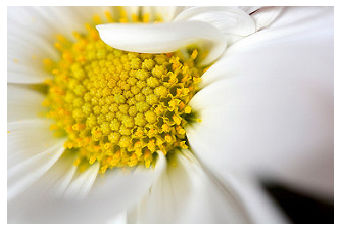

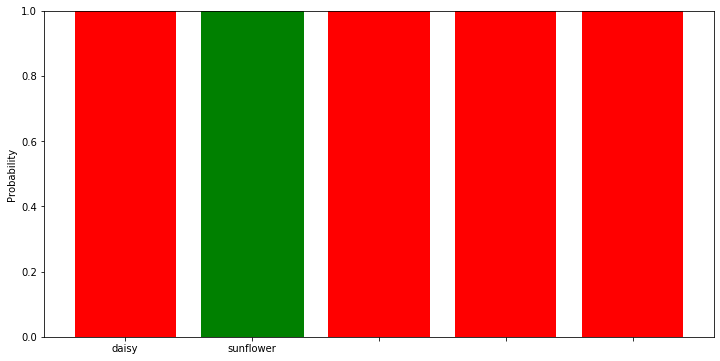

In [97]:
import_and_predict_bayes(image1_dir,label.index('sunflower'))